In [8]:
import random
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.stats
import datetime as dt

import FXOption_class

In [9]:
#for graphs to be contained inside notebook
%matplotlib inline

In [11]:
#code check debug
volume = 25000
dev = 2500
mean = 2*math.log(volume) - 0.5*math.log(dev*dev+ volume * volume)
var = -2 * math.log(volume) + math.log(dev *dev + volume * volume)
stdev = math.sqrt(var)
print(mean, stdev)
for i in range(5):
    xp = np.random.lognormal(mean, stdev)
    print(xp)

10.121655938423753 0.09975134511959609
24157.27421973455
24413.449448113846
27017.821835016846
25560.607540999026
28973.20458809752


In [2]:
'''https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.lognormal.html
 Note that the mean and standard deviation are not the values for the distribution itself,
but of the underlying normal distribution it is derived from, thus transforming using: 

https://ocw.mit.edu/courses/civil-and-environmental-engineering/1-151-probability-
     and-statistics-in-engineering-spring-2005/lecture-notes/briefnts8_relnl.pdf''' 

'https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.lognormal.html\n Note that the mean and standard deviation are not the values for the distribution itself,\nbut of the underlying normal distribution it is derived from, thus transforming using: \n\nhttps://ocw.mit.edu/courses/civil-and-environmental-engineering/1-151-probability-\n     and-statistics-in-engineering-spring-2005/lecture-notes/briefnts8_relnl.pdf'

In [24]:
class HedgeBase(object):
    
    def __init__(self, revs_unit_price_local, \
                 mean_volume_log, sigma_volume_log, \
                 mean_spot_log, sigma_spot_log, var_cost, fixed_cost):
        
        self.revs_unit_price_local = revs_unit_price_local  #deterministic price of whatever client sells, say in USD
        
        self.mean_volume_log = mean_volume_log   #stochastic expected mean of volumes sold
        self.sigma_volume_log = sigma_volume_log  #stochastic expected stDev of volumes sold.  
        
        self.mean_spot_log = mean_spot_log  #expected FX rate, can use forward
        self.sigma_spot_log =  sigma_spot_log #expected FX vol, can use at-the money implieds
        
        self.var_cost = var_cost     #cost per each unit sold
        self.fixed_cost = fixed_cost  #fixed cost
        
    #helper method, takes as input lognormal mean and stdev, transforms to normal, and makes a random draw
    def _draw_volume_(self):#  dont need the other 2 args,mean_volume_log, sigma_volume_log):
        
        mean_volume_norm = 2*math.log(self.mean_volume_log) - 0.5*math.log((self.sigma_volume_log**2) \
                                                                           + self.mean_volume_log **2)
        variance_volume_norm = -2 * math.log(self.mean_volume_log) + math.log((self.sigma_volume_log **2) + self.mean_volume_log**2)
        
        sigma_volume_norm = math.sqrt(variance_volume_norm)
    
        volume = np.random.lognormal(mean_volume_norm, sigma_volume_norm)
        return volume
    
    #helper method, takes as input lognormal mean and stdev, transforms to normal, and makes a random draw
    def _draw_spot_(self):
        
        mean_spot_norm = 2*math.log(self.mean_spot_log) - 0.5*math.log((self.sigma_spot_log**2) \
                                                                       + self.mean_spot_log **2)
        variance_spot_norm = -2 * math.log(self.mean_spot_log) + math.log((self.sigma_spot_log **2)\
                                                                     +  self.mean_spot_log**2)
        sigma_spot_norm = math.sqrt(variance_spot_norm)
        
        spot  = np.random.lognormal(mean_spot_norm,sigma_spot_norm)
    
        return spot

    def montecarlo(self, num_draws):
        
         #i receive USD but have expenses in EUR, thus im short EURUSD so i buy if hedged#
        
        self.profit_vec = []
        draws = 0
        
        while draws <= num_draws:
            
            profit = self._payoff_profile_()
            self.profit_vec.append(profit)  #
            draws += 1
   
        self.mean_profit = np.mean(self.profit_vec)
        self.min_profit = min(self.profit_vec)
        self.std_profit = np.std(self.profit_vec)
        self.skew_profit = scipy.stats.skew(self.profit_vec)
        
        return (self.mean_profit, self.min_profit, self.std_profit, self.skew_profit)
        
    
    def display(self, num_draws):
        
        self.montecarlo(num_draws)
        print('mean '+str(self.mean_profit))
        print('stDev: '+str(self.std_profit)) 
        print('min :' +str(self.min_profit))
        print('skew :' +str(self.skew_profit))
        count, bins, ignored = plt.hist(self.profit_vec , 100, normed = True, color = 'orange')
        plt.plot()
    
    
    def __str__(self):
        return "(%0.2f, %0.2f)"%(self.revs_unit_price_local, self.mean_volume_log)


In [25]:
class HedgeNone(HedgeBase):
    def __init__(self,  revs_unit_price_local, \
                 mean_volume_log, sigma_volume_log, \
                 mean_spot_log, sigma_spot_log, var_cost, fixed_cost):
        HedgeBase.__init__(self, revs_unit_price_local, \
                           mean_volume_log, sigma_volume_log, \
                           mean_spot_log, sigma_spot_log, var_cost, fixed_cost)
    
    def _payoff_profile_(self):
        
        volume = self._draw_volume_()
        #spot = draw_spot_(self.mean_spot_log, self.sigma_spot_log)  or
        spot = self._draw_spot_()
        self.profit = self.revs_unit_price_local * volume - spot * self.var_cost * volume - self.fixed_cost 
        
        return self.profit        

In [55]:
class HedgeForward(HedgeBase):
    def __init__(self,  revs_unit_price_local, \
                 mean_volume_log, sigma_volume_log, \
                 mean_spot_log, sigma_spot_log, var_cost, fixed_cost, hedge_percentage):
        
        self.hedge_percentage = hedge_percentage
        
        HedgeBase.__init__(self, revs_unit_price_local, \
                           mean_volume_log, sigma_volume_log, \
                           mean_spot_log, sigma_spot_log, var_cost, fixed_cost)
                           

    def _payoff_profile_(self):
        
        volume = self._draw_volume_()
        #spot = draw_spot_(self.mean_spot_log, self.sigma_spot_log)  or
        spot = self._draw_spot_()
    
        hedge_notional = self.hedge_percentage *  self.mean_volume_log*self.var_cost  
        forward_rate_t0 = self.mean_spot_log #can make it actual forward later 
        
        self.profit = self.revs_unit_price_local * volume - spot * self.var_cost * volume - self.fixed_cost +hedge_notional*\
            (spot - forward_rate_t0)
            
        return self.profit  

In [71]:
class HedgeFXO(HedgeBase):
    
    def __init__(self, revs_unit_price_local, \
                 mean_volume_log, sigma_volume_log, \
                 mean_spot_log, sigma_spot_log, var_cost, fixed_cost, \
                strike, vol, r_dom, r_for, time, notional ):
        
        self.strike = strike
        self.vol = vol
        self.r_dom = r_dom
        self.r_for = r_for
        self.time = time
        self.notional = notional
        
        
        HedgeNone.__init__(self, revs_unit_price_local, \
                           mean_volume_log, sigma_volume_log, \
                           mean_spot_log, sigma_spot_log, var_cost, fixed_cost)
        
    def _payoff_profile_(self): 
        
        volume = self._draw_volume_()
        spot = self._draw_spot_()
        
        hedge_notional = self.mean_volume_log * self.var_cost
        strike = self.mean_spot_log
        premium = FXOption_class.FXOption("Call", self.mean_spot_log,  self.strike,  self.vol,  self.r_dom, \
                                          self.r_for, self.time, self.notional, "").price()
        
        #print('premium is '+str(premium))
        self.profit = self.revs_unit_price_local * volume - spot * self.var_cost *volume - self.fixed_cost + hedge_notional * \
        max(spot - strike, 0.0) - premium
        return self.profit

mean 2253415.17891
stDev: 3087713.00652
min :-13279002.090202708
skew :-0.23492942683159343


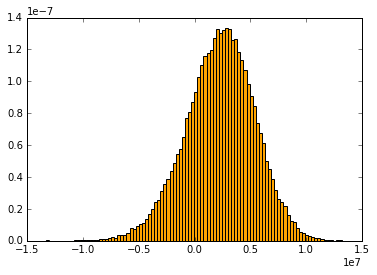

In [75]:
sales_price = 1350
expected_volume = 25000
expected_volume_deviation = expected_volume * 0.1
expected_spot = 1.22
st_dev_spot = expected_spot * 0.1
cost_per_unit = 1000
fixed_cost = 1000000


unhedged = HedgeNone(sales_price, expected_volume, expected_volume_deviation, expected_spot, st_dev_spot, cost_per_unit,\
                     fixed_cost)
unhedged.display(100000)

mean 2250174.23147
stDev: 542149.515925
min :-1146653.3361379784
skew :1.1830861853216637


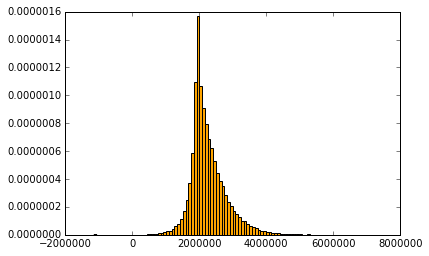

In [60]:
forward = HedgeForward(sales_price, expected_volume, expected_volume_deviation, expected_spot, st_dev_spot, cost_per_unit,\
                     fixed_cost, 0.9)
forward.display(100000)

mean 2103031.45823
stDev: 1730974.01934
min :-1029756.26558
skew :1.5309554584155245


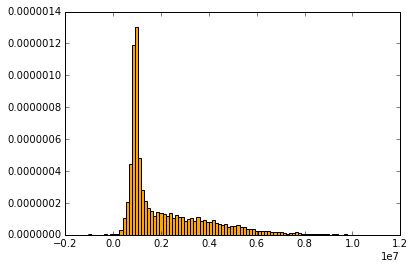

In [73]:
option = HedgeFXO(sales_price, expected_volume, expected_volume_deviation, expected_spot, st_dev_spot, cost_per_unit,\
                     fixed_cost, 1.14, 0.10, 0, 0, 1, sales_price * expected_volume)
option.display(10000)

In [11]:
import sys

In [14]:
print(sys.path)

['', 'C:\\Users\\cp85vc\\AppData\\Local\\Continuum\\Anaconda3\\python35.zip', 'C:\\Users\\cp85vc\\AppData\\Local\\Continuum\\Anaconda3\\DLLs', 'C:\\Users\\cp85vc\\AppData\\Local\\Continuum\\Anaconda3\\lib', 'C:\\Users\\cp85vc\\AppData\\Local\\Continuum\\Anaconda3', 'c:\\users\\cp85vc\\appdata\\local\\continuum\\anaconda3\\lib\\site-packages\\setuptools-20.3-py3.5.egg', 'C:\\Users\\cp85vc\\AppData\\Local\\Continuum\\Anaconda3\\lib\\site-packages', 'C:\\Users\\cp85vc\\AppData\\Local\\Continuum\\Anaconda3\\lib\\site-packages\\Sphinx-1.3.5-py3.5.egg', 'C:\\Users\\cp85vc\\AppData\\Local\\Continuum\\Anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\cp85vc\\AppData\\Local\\Continuum\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\cp85vc\\AppData\\Local\\Continuum\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\cp85vc\\AppData\\Local\\Continuum\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\cp85vc\\.ipython']
